In [23]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score



Populating the interactive namespace with required modules and packages

In [24]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
#concatenate for cleaning
data=pd.concat([train,test], axis=0, sort=False)

data.reset_index()

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  4705 non-null float64
Item_Fat_Content  

We can see several issues in the data, namely item weight and outlet size have null values. We will fill with item weight mean and outlet size mode.

In [25]:
#fill nulls in item weight
data['Item_Weight']=data['Item_Weight'].fillna(data['Item_Weight'].mean())

data.info()
#Fill nulls in outlet size
#find outlet size mode, is 'Medium'

data['Outlet_Size'].value_counts()
data['Outlet_Size']=data['Outlet_Size'].fillna('Medium')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
Item_Identifier              14204 non-null object
Item_Weight                  14204 non-null float64
Item_Fat_Content             14204 non-null object
Item_Visibility              14204 non-null float64
Item_Type                    14204 non-null object
Item_MRP                     14204 non-null float64
Outlet_Identifier            14204 non-null object
Outlet_Establishment_Year    14204 non-null int64
Outlet_Size                  10188 non-null object
Outlet_Location_Type         14204 non-null object
Outlet_Type                  14204 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
Item_Identifier              14204 non-null object
Item_Weight                  14204 non-null float64
Item_

In [15]:

#Clean data in item fat content

for feat in data:
  if data[feat].dtype=='object':
    print(data[feat].unique())

#replace values for uniqueness
data['Item_Fat_Content']=data['Item_Fat_Content'].replace({'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular'})


['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' 'High' 'Small']
['Tier 1' 'Tier 3' 'Tier 2']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


We cleaned the inconsistent naming of the low fat and regular labels in the item fat content column.

In [6]:

#now ordinal encode for XGB

for feat in data.columns:
  if data[feat].dtype =='object':
    data[feat]=pd.Categorical(data[feat]).codes
    
data.info()

clean_train=data[:train.shape[0]]
clean_test=data[train.shape[0]:]


train_targ=clean_train.pop('Item_Outlet_Sales')
test_targ=clean_test.pop('Item_Outlet_Sales')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 14204 entries, 0 to 5680
Data columns (total 12 columns):
Item_Fat_Content             14204 non-null int8
Item_Identifier              14204 non-null int16
Item_MRP                     14204 non-null float64
Item_Outlet_Sales            8523 non-null float64
Item_Type                    14204 non-null int8
Item_Visibility              14204 non-null float64
Item_Weight                  14204 non-null float64
Outlet_Establishment_Year    14204 non-null int64
Outlet_Identifier            14204 non-null int8
Outlet_Location_Type         14204 non-null int8
Outlet_Size                  14204 non-null int8
Outlet_Type                  14204 non-null int8
dtypes: float64(4), int16(1), int64(1), int8(6)
memory usage: 776.8 KB


We ordinal encode to convert all columns to numerical values to be compatible with XGBoost.
Tree boosting removes the bias generated by the numerical values generated by ordinal encoding.

In [7]:
##Optimize parameters for gradient boosting
#first optimization

cv_params1={'max_depth':[3,5,7], 'min_child_weight':[1,3,5]}

ind_params1={'learning_rate': 0.1 , 'n_estimators':1000, 'seed':123, 'subsample':0.8, 'colsample_bytree':0.8, 'objective':'reg:linear' }

optimized_GBM=GridSearchCV(xgb.XGBRegressor(**ind_params1), cv_params1, scoring='r2', cv=5, n_jobs=-1)

optimized_GBM.fit(clean_train, train_targ)

print("Best parameters found: ",optimized_GBM.best_params_)
print("Score found: ", optimized_GBM.best_score_)

#second optimization: subsampling

cv_params2={'learning_rate': [0.1,0.01], 'subsample': [0.7,0.8,0.9]}
ind_params2={'n_estimatiors':1000, 'seed':123, 'colsample_bytree':0.8, 'objective':'reg:linear', 'max_depth':3, 'min_child_weight':5}


optimized_GBM2=GridSearchCV(xgb.XGBRegressor(**ind_params2), cv_params2, scoring='r2', cv=5, n_jobs=-1)

optimized_GBM2.fit(clean_train, train_targ)


print("Best parameters found: ",optimized_GBM2.best_params_)
print("Score found: ", optimized_GBM2.best_score_)

Best parameters found:  {'max_depth': 3, 'min_child_weight': 5}
Score found:  0.5464626901778392
Best parameters found:  {'learning_rate': 0.1, 'subsample': 0.8}
Score found:  0.5936171741968586


We optimized our parameters for XGB and found the above parameters worked the best with the r^2 score shown above.

In [8]:
#setup for xgb using best params

xgdmat=xgb.DMatrix(clean_train,train_targ)
cv_params={'eta':0.1, 'seed':123, 'subsample':0.8, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'max_depth':3, 'min_child_weight':5, 'learning_rate':0.1}

xgb_cv=xgb.cv(params=cv_params, dtrain=xgdmat, num_boost_round=3000, nfold=5, metrics=['error'], early_stopping_rounds=100)

print(xgb_cv.tail(5))

final_params={'eta':0.1, 'seed':123, 'subsample':0.8, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'max_depth':3, 'min_child_weight':5, 'learning_rate':0.1}

model=xgb.train(final_params, xgdmat)


[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end

[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[14:32:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3


Created the model for xgboost and trained the data on it.

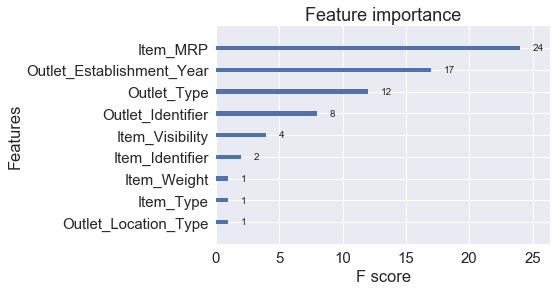

In [9]:
#plot feature importance
xgb.plot_importance(model)

array([1176.8944 ,  950.63684,  405.62418, ..., 1376.0967 , 2077.0505 ,
        872.0071 ], dtype=float32)

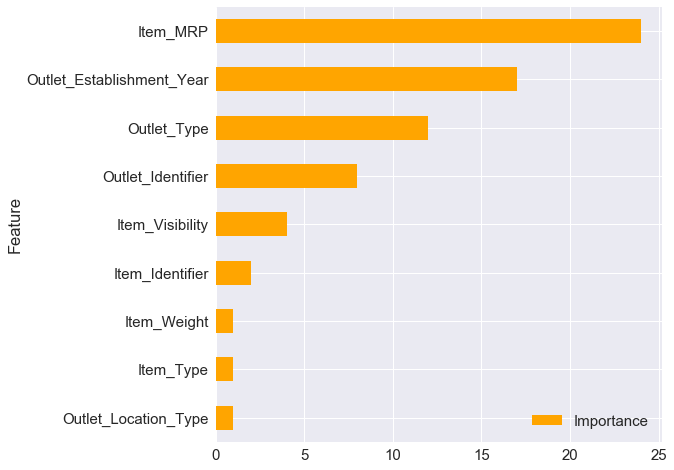

In [10]:
#use seaborn to plot

sns.set(font_scale=1.5)
importances = model.get_fscore()
importances

importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')



testdmat=xgb.DMatrix(clean_test)
y_pred=model.predict(testdmat)
y_pred

Plotted the feature importance of the model. As expected, retail price is the most important feature.

In [11]:
#save our submission data for leaderboards at https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/lb


test['Item_Outlet_Sales']=y_pred

test=test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
test.set_index('Item_Identifier')
test.to_csv('Submission.csv', index='Item_Identifier')

Saved submission data to test against actual sales data.